In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random

from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications import Xception, InceptionV3, VGG16
from keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
import warnings

warnings.filterwarnings('ignore') 

In [2]:
# Define base path to your local dataset
path = os.path.expanduser('~/Desktop/Predictive_Analytics/deep_learning/CNN/image_classification')

# Corrected directory paths
train_dir = path + '/seg_train'
val_dir = path + '/seg_test'
test_dir = path + '/seg_pred'

# Check and print class labels in the training set
labels = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
print("Class labels found in training set:", labels)

Class labels found in training set: ['forest', 'buildings', 'glacier', 'street', 'mountain', 'sea']


In [3]:
# Getting the total number of images in each class
tot = dict()
for label in labels:
    direc = train_dir + '/' + label
    tot[label] = len(os.listdir(direc))
print(tot)
min_sample = min(tot.values())
print(min_sample)

{'forest': 2271, 'buildings': 2191, 'glacier': 2404, 'street': 2382, 'mountain': 2512, 'sea': 2274}
2191


## Visualizing random images in dataset

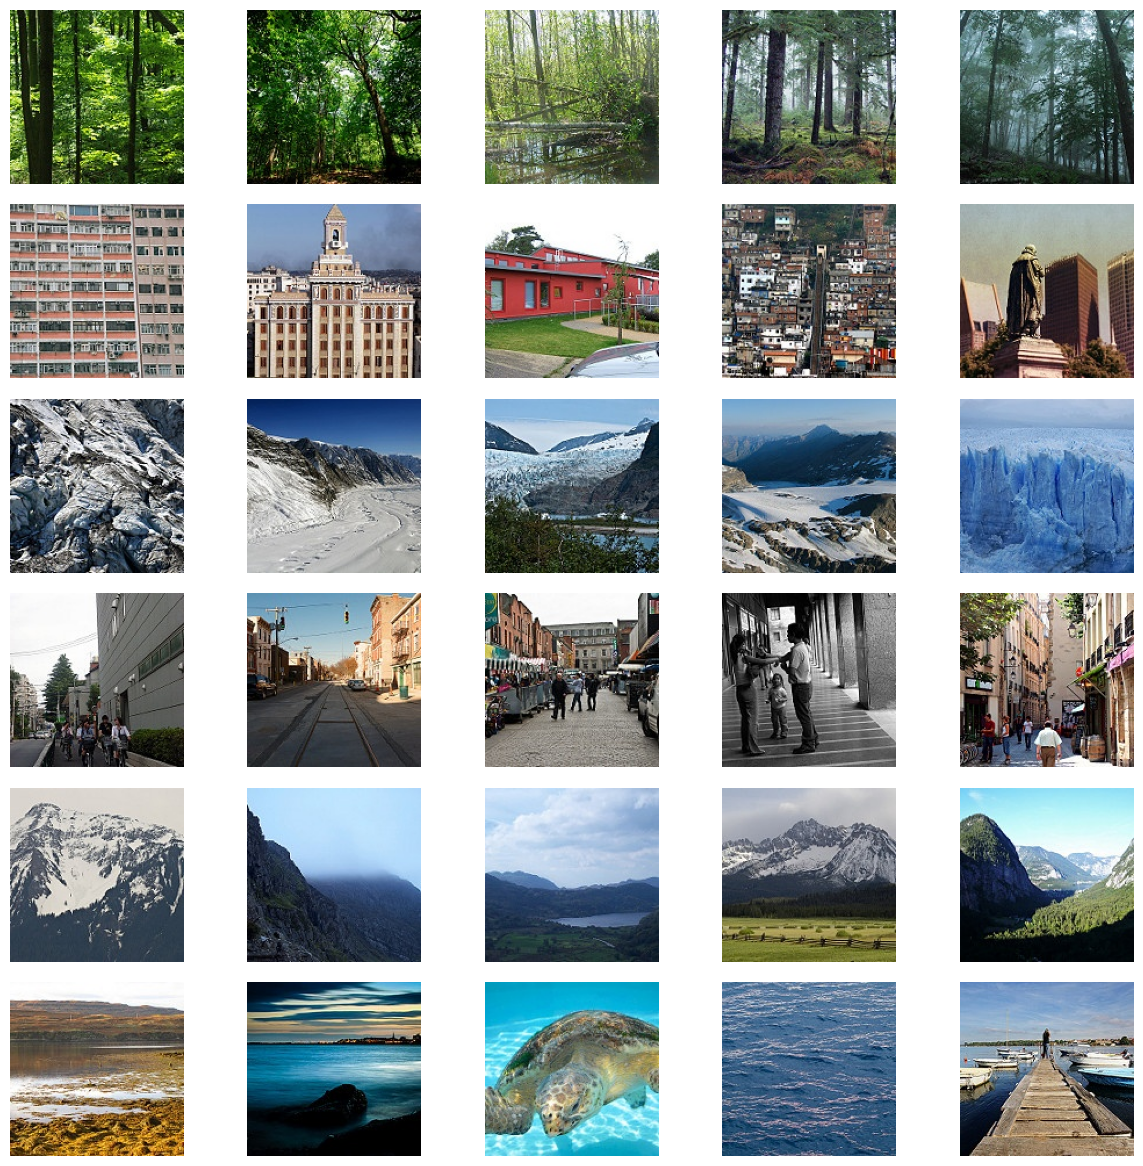

In [4]:
min_ = 1
max_ = 6
count = 0
plt.figure(figsize=(12, 12))
for label in labels:
    min_ += count
    max_ += count
    count = 5
    for i in range(min_, max_):
        path = train_dir + '/' + label
        plt.subplot(6, 5, i)
        plt.tight_layout()
        rand_img = plt.imread(path + '/' + random.choice(sorted(os.listdir(path))))
        plt.axis('off')
        plt.imshow(rand_img)
        # Plotting Dimensions of images
        plt.xlabel(label, fontsize=10)
        plt.ylabel(rand_img.shape, fontsize=10)

## Get train and validation generator

In [5]:
# Batch size
batch_size = 12

# Train Generator
train_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(150,150),
                                                   batch_size=batch_size,
                                                   class_mode='categorical')

# Validation generator
val_datagen = ImageDataGenerator(rescale=1/255)
val_generator = val_datagen.flow_from_directory(val_dir,
                                                   target_size=(150,150),
                                                   batch_size=batch_size,
                                                   class_mode='categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


## Model Building

In [6]:
k = len(labels)
print('Number of Classes:', k)

Number of Classes: 6


## Xception Model

In [7]:
# Building the Model
xcept = Xception(
    input_shape= (150, 150, 3),
    weights = 'imagenet',
    include_top = False
)
# Freeze pretrained model weights
xcept.trainable = False

# map date
x = Flatten()(xcept.output)
x = Dense(k, activation='softmax')(x)

xception = Model(inputs = xcept.input, outputs = x)

xception.compile(optimizer= Adam(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

xception.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 74, 74,    │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 74, 74,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 74, 74,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 72, 72,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 72, 72,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 72, 72,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 72, 72,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 72, 72,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 72, 72,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 72, 72,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 72, 72,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 36, 36,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 36, 36,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 36, 36,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 36, 36,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 36, 36,    │          0 │ add[0][0]       

 Total params: 21,168,686 (80.75 MB)

 Trainable params: 307,206 (1.17 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [8]:
steps_per_epoch = min_sample//batch_size

history = xception.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    verbose=1,
    validation_data = val_generator,
    validation_steps=steps_per_epoch
)

Epoch 1/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 45s 243ms/step - accuracy: 0.7514 - loss: 0.6435 - val_accuracy: 0.8887 - val_loss: 0.3294
Epoch 2/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 43s 238ms/step - accuracy: 0.8915 - loss: 0.3120 - val_accuracy: 0.8782 - val_loss: 0.3497
Epoch 3/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 44s 244ms/step - accuracy: 0.8971 - loss: 0.3167 - val_accuracy: 0.8915 - val_loss: 0.3184
Epoch 4/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 44s 240ms/step - accuracy: 0.9028 - loss: 0.2876 - val_accuracy: 0.8759 - val_loss: 0.3699
Epoch 5/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 44s 241ms/step - accuracy: 0.9072 - loss: 0.2653 - val_accuracy: 0.8755 - val_loss: 0.3738
Epoch 6/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 44s 243ms/step - accuracy: 0.9135 - loss: 0.2544 - val_accuracy: 0.9080 - val_loss: 0.2719
Epoch 7/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 32s 173ms/step - accuracy: 0.9293 - loss: 0.1963 - val_accuracy: 0.8828 - val_loss: 0.3676
Epoch 8/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 45s 246ms/step - accuracy: 0.9274 - loss: 0

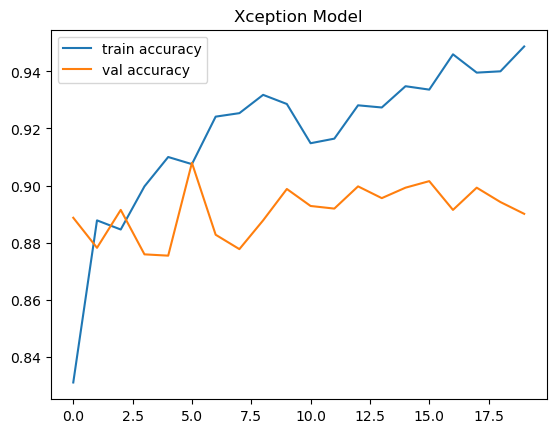

In [9]:
# Plot accouracy per iteration
plt.plot(history.history['accuracy'], label= 'train accuracy')
plt.plot(history.history['val_accuracy'], label= 'val accuracy')
plt.title("Xception Model")
plt.legend()
plt.show()

## InceptionV3

In [10]:
# Building the Model
incept = InceptionV3(
    input_shape= (150, 150, 3),
    weights = 'imagenet',
    include_top = False
)
# Freeze pretrained model weights
incept.trainable = False

# map date
x = Flatten()(incept.output)
x = Dense(k, activation='softmax')(x)

inceptionV3 = Model(inputs = incept.input, outputs = x)

inceptionV3.compile(optimizer= Adam(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

inceptionV3.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 74, 74,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 74, 74,    │         96 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 72, 72,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 72, 72,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 35, 35,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 35, 35,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 33, 33,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 21,913,382 (83.59 MB)

 Trainable params: 110,598 (432.02 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [11]:
steps_per_epoch = min_sample//batch_size

history = inceptionV3.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    verbose=1,
    validation_data = val_generator,
    validation_steps=steps_per_epoch
)

Epoch 1/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 26s 137ms/step - accuracy: 0.6281 - loss: 1.1116 - val_accuracy: 0.8324 - val_loss: 0.4981
Epoch 2/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 26s 142ms/step - accuracy: 0.8334 - loss: 0.5278 - val_accuracy: 0.8636 - val_loss: 0.3991
Epoch 3/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 26s 144ms/step - accuracy: 0.8701 - loss: 0.3863 - val_accuracy: 0.8645 - val_loss: 0.4451
Epoch 4/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 26s 144ms/step - accuracy: 0.8872 - loss: 0.3576 - val_accuracy: 0.8645 - val_loss: 0.4325
Epoch 5/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 26s 144ms/step - accuracy: 0.8888 - loss: 0.3217 - val_accuracy: 0.8439 - val_loss: 0.4552
Epoch 6/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 26s 142ms/step - accuracy: 0.8874 - loss: 0.3256 - val_accuracy: 0.8846 - val_loss: 0.3683
Epoch 7/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 18s 101ms/step - accuracy: 0.9184 - loss: 0.2760 - val_accuracy: 0.8810 - val_loss: 0.3610
Epoch 8/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 26s 145ms/step - accuracy: 0.8922 - loss: 0

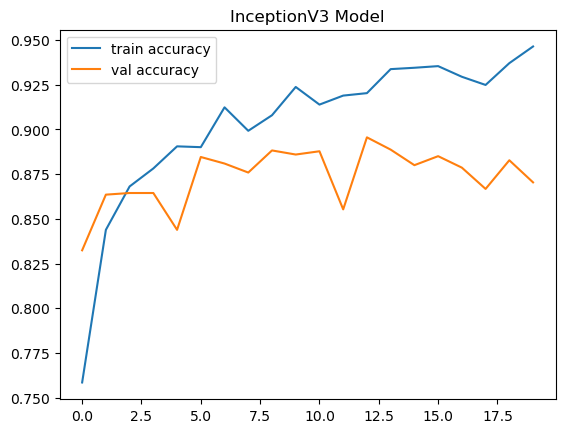

In [12]:
# Plot accouracy per iteration
plt.plot(history.history['accuracy'], label= 'train accuracy')
plt.plot(history.history['val_accuracy'], label= 'val accuracy')
plt.title("InceptionV3 Model")
plt.legend()
plt.show()

## VGG16

In [13]:
# Building the Model
vgg16 = VGG16(
    input_shape= (150, 150, 3),
    weights = 'imagenet',
    include_top = False
)
# Freeze pretrained model weights
vgg16.trainable = False

# map date
x = Flatten()(vgg16.output)
x = Dense(k, activation='softmax')(x)

vgg16_model = Model(inputs = vgg16.input, outputs = x)

vgg16_model.compile(optimizer= Adam(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

vgg16_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │        49,158 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,763,846 (56.32 MB)

 Trainable params: 49,158 (192.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [14]:
steps_per_epoch = min_sample//batch_size

history = vgg16_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    verbose=1,
    validation_data = val_generator,
    validation_steps=steps_per_epoch
)

Epoch 1/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 110s 607ms/step - accuracy: 0.4755 - loss: 1.4107 - val_accuracy: 0.7788 - val_loss: 0.7735
Epoch 2/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 110s 606ms/step - accuracy: 0.7775 - loss: 0.7254 - val_accuracy: 0.8182 - val_loss: 0.5917
Epoch 3/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 112s 618ms/step - accuracy: 0.8050 - loss: 0.5843 - val_accuracy: 0.8352 - val_loss: 0.5224
Epoch 4/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 111s 610ms/step - accuracy: 0.8255 - loss: 0.5059 - val_accuracy: 0.8425 - val_loss: 0.4822
Epoch 5/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 115s 634ms/step - accuracy: 0.8516 - loss: 0.4589 - val_accuracy: 0.8521 - val_loss: 0.4507
Epoch 6/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 111s 610ms/step - accuracy: 0.8527 - loss: 0.4419 - val_accuracy: 0.8549 - val_loss: 0.4356
Epoch 7/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 79s 436ms/step - accuracy: 0.8503 - loss: 0.4326 - val_accuracy: 0.8434 - val_loss: 0.4525
Epoch 8/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 471s 3s/step - accuracy: 0.8809 - los

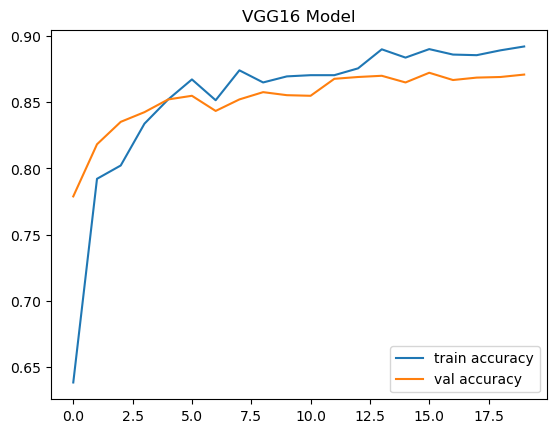

In [15]:
# Plot accouracy per iteration
plt.plot(history.history['accuracy'], label= 'train accuracy')
plt.plot(history.history['val_accuracy'], label= 'val accuracy')
plt.title("VGG16 Model")
plt.legend()
plt.show()

 We can deduce that the **Xception** model has a slighly higher validation score than **InceptionV3** and **VGG16**

## Saving Model

In [16]:
xception.save('intel_image.h5')

## Testing Model

In [17]:
# loading the model
model = load_model('intel_image.h5')

In [18]:
model.save('intel_image_cleaned.h5')

In [19]:
labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

## Visual Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


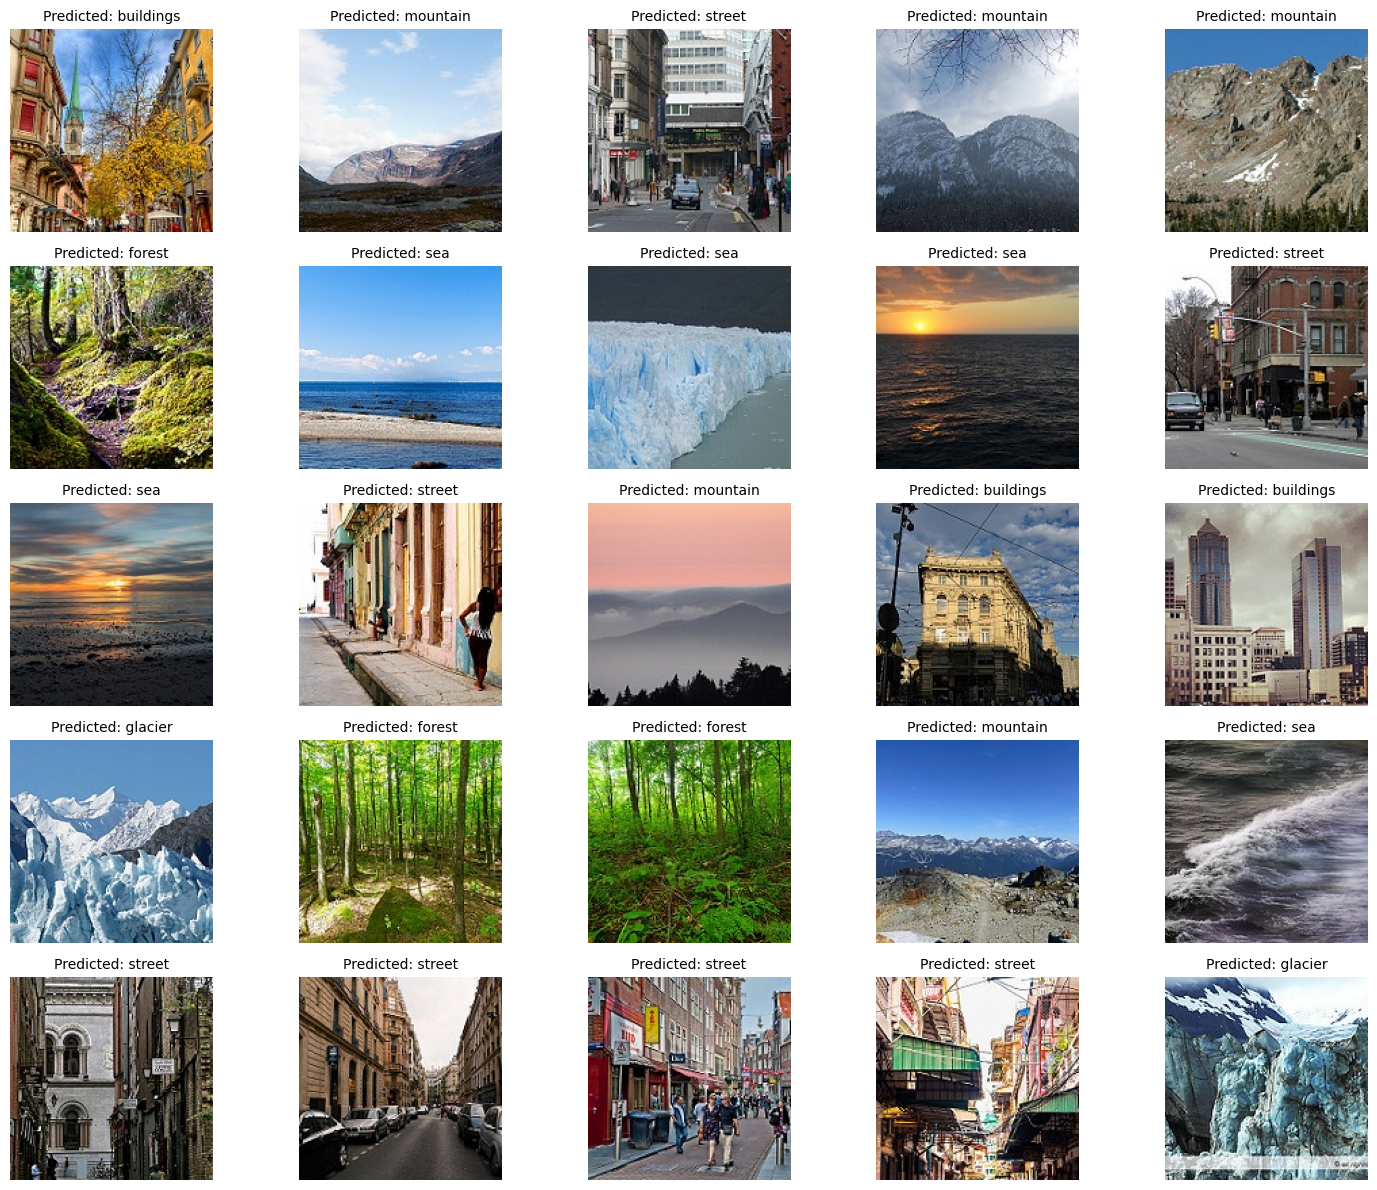

In [20]:
# --- Paths ---
base_path = os.path.expanduser('~/Desktop/Predictive_Analytics/deep_learning/CNN/image_classification/seg_pred')  # Flat image folder

# --- Collect all image files ---
image_files = [f for f in sorted(os.listdir(base_path)) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# --- Display predictions on first 25 images ---
plt.figure(figsize=(15, 12))

for i, img_file in enumerate(image_files[:25]):
    img_path = os.path.join(base_path, img_file)
    
    # Load and preprocess image
    img = load_img(img_path, target_size=(150, 150))
    img_arr = img_to_array(img)
    X = np.expand_dims(img_arr, axis=0) / 255.0  # Normalize

    # Predict
    pred = np.argmax(model.predict(X), axis=1)[0]
    result = labels[pred]

    # Plot
    plt.subplot(5, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Predicted: {result}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

These examples demonstrate that the model is making reasonable predictions based on visual similarities, indicating strong overall performance in classifying the images.